Importando bibliotecas necessárias para o desenvolvimento

In [149]:
import requests
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import openai
from keys import openai_key, nasa_key
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.linear_model import LogisticRegression as LR
from xgboost import XGBClassifier as XGB
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from imblearn.over_sampling import ADASYN

warnings.simplefilter(action='ignore')

Criando variáveis e consumindo a API da Nasa

In [150]:
nasa_key = nasa_key


base_url = 'https://api.nasa.gov/neo/rest/v1/feed'


start_date = (datetime.now() - timedelta(days=7)).strftime('%Y-%m-%d')
end_date = datetime.now().strftime('%Y-%m-%d')

params = {
    'start_date': start_date,
    'end_date': end_date,
    'api_key': nasa_key
}

response = requests.get(base_url, params=params)
data = response.json()

Configurando a Gen AI do OpenAI

In [151]:
openai.api_key = openai_key
headers = {'Authorization': f'Bearer {openai_key}', 'Content-Type': 'application/json'}
link = 'https://api.openai.com/v1/chat/completions'
id_model = 'gpt-4o'

def get_ai_response(prompt):
    body_message = {
        'model': id_model,
        'messages': [{'role': 'user', 'content': prompt}]
    }

    response_ai = requests.post(link, headers=headers, json=body_message)  # Use json= para enviar o corpo como JSON
    return response_ai.json()

Tratando a api e gerando uma lista com os dados que foram selecionados

In [152]:
asteroids = []
for date, asteroids_list in data['near_earth_objects'].items():
    for asteroid in asteroids_list:
        asteroids.append({
            'name': asteroid['name'],
            'close_approach_date': date,
            'relative_velocity_kmh': asteroid['close_approach_data'][0]['relative_velocity']['kilometers_per_hour'],
            'estimated_diameter_min': asteroid['estimated_diameter']['meters']['estimated_diameter_min'],
            'estimated_diameter_max': asteroid['estimated_diameter']['meters']['estimated_diameter_max'],
            "miss_distance_km": asteroid['close_approach_data'][0]['miss_distance']['kilometers'],
            'absolute_magnitude_h': asteroid['absolute_magnitude_h'],
            'is_potentially_hazardous': asteroid['is_potentially_hazardous_asteroid']
        })

### Explicando as variáveis  
**name**: Nome dado ao asteroide.

**close_approach_date**: Data em que se aproximou da Terra.

**relative_velocity_kmh**: Velocidade do asteroide. Velocidades maiores podem aumentar a energia do impacto, caso ele ocorra.

**estimated_diameter_min** e **estimated_diameter_max**: Intervalo de diâmetro estimado. Asteroides maiores tendem a ter um impacto mais significativo se colidirem com a Terra, o que pode correlacionar com o potencial de risco.

**estimated_diameter_mean**: Média entre diâmetro mínimo e diâmetro máximo estimado.

**miss_distance_km**: Distância mínima entre o asteroide e a Terra durante a passagem. Asteroides com menor distância de aproximação podem ser considerados mais arriscados.

**is_potentially_hazardous**: Diz se é potencialmente perigou ou não.

**absolute_magnitude_h**: Brilho absoluto do asteroide, que pode estar relacionado ao seu tamanho e ao potencial de perigo.

Criando o DataFrame a partir da lista 'asteroids'

In [153]:
df_asteroids = pd.DataFrame(asteroids)

Visualizando as primeiras linhas

In [154]:
df_asteroids.head()

,name,close_approach_date,relative_velocity_kmh,estimated_diameter_min,estimated_diameter_max,miss_distance_km,absolute_magnitude_h,is_potentially_hazardous
0,412977 (1990 UO),2024-10-20,148185.7480262956,324.007435,724.502651,69887104.254764291,19.57,False
1,495615 (2015 PQ291),2024-10-20,82317.0440716297,766.575574,1714.115092,52394019.758446318,17.70,False
2,526742 (2006 WR127),2024-10-20,53453.4606550249,212.106988,474.285643,41208195.072126918,20.49,False
3,(2014 US115),2024-10-20,68985.4822516714,31.956189,71.456210,57336403.669540838,24.60,False
4,(2015 KG19),2024-10-20,27404.305513672,55.789822,124.749835,33890943.164648171,23.39,False


Criando o diametro estimado médio para cada asteroide

In [155]:
df_asteroids['estimated_diameter_mean'] = (df_asteroids['estimated_diameter_max'] + df_asteroids['estimated_diameter_min']) / 2

In [156]:
df_asteroids

,name,close_approach_date,relative_velocity_kmh,estimated_diameter_min,estimated_diameter_max,miss_distance_km,absolute_magnitude_h,is_potentially_hazardous,estimated_diameter_mean
0,412977 (1990 UO),2024-10-20,148185.7480262956,324.007435,724.502651,69887104.254764291,19.570,False,524.255043
1,495615 (2015 PQ291),2024-10-20,82317.0440716297,766.575574,1714.115092,52394019.758446318,17.700,False,1240.345333
2,526742 (2006 WR127),2024-10-20,53453.4606550249,212.106988,474.285643,41208195.072126918,20.490,False,343.196316
3,(2014 US115),2024-10-20,68985.4822516714,31.956189,71.456210,57336403.669540838,24.600,False,51.706199
4,(2015 KG19),2024-10-20,27404.305513672,55.789822,124.749835,33890943.164648171,23.390,False,90.269828
...,...,...,...,...,...,...,...,...,...
146,(2024 TQ3),2024-10-22,30556.439124071,56.306039,125.904131,24102959.659147515,23.370,False,91.105085
147,(2024 UL),2024-10-22,45149.7846019396,57.856876,129.371907,12783126.726780389,23.311,False,93.614391
148,(2024 UR),2024-10-22,58738.2447017531,36.505221,81.628155,2109025.924289012,24.311,False,59.066688
149,(2024 US),2024-10-22,28168.3001281375,6.876303,15.375880,362461.741367877,27.936,False,11.126091


Visualizando informações sobre o DataFrame, como o tipo de dado de cada coluna

In [157]:
df_asteroids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      151 non-null    object 
 1   close_approach_date       151 non-null    object 
 2   relative_velocity_kmh     151 non-null    object 
 3   estimated_diameter_min    151 non-null    float64
 4   estimated_diameter_max    151 non-null    float64
 5   miss_distance_km          151 non-null    object 
 6   absolute_magnitude_h      151 non-null    float64
 7   is_potentially_hazardous  151 non-null    bool   
 8   estimated_diameter_mean   151 non-null    float64
dtypes: bool(1), float64(4), object(4)
memory usage: 9.7+ KB


Ajustando o tipo de dados para as colunas necessárias

In [158]:
df_asteroids['close_approach_date'] = pd.to_datetime(df_asteroids['close_approach_date'])

df_asteroids['miss_distance_km'] = df_asteroids['miss_distance_km'].astype('float64')

df_asteroids['relative_velocity_kmh'] = df_asteroids['relative_velocity_kmh'].astype('float64')

Descrição estatítisca dos dados das colunas de data e numéricas

In [159]:
df_asteroids.describe()

,close_approach_date,relative_velocity_kmh,estimated_diameter_min,estimated_diameter_max,miss_distance_km,absolute_magnitude_h,estimated_diameter_mean
count,151,151.000000,151.000000,151.000000,1.510000e+02,151.000000,151.000000
mean,2024-10-23 06:02:23.046357504,44430.402871,99.683752,222.899645,3.400922e+07,24.096841,161.291698
min,2024-10-20 00:00:00,4966.978391,2.731209,6.107170,4.636481e+04,16.550000,4.419189
25%,2024-10-21 00:00:00,28152.961156,16.803398,37.573540,1.300053e+07,22.295000,27.188469
50%,2024-10-23 00:00:00,40633.241906,32.400744,72.450265,3.252080e+07,24.570000,52.425504
75%,2024-10-25 00:00:00,56943.736224,92.381234,206.570719,5.652808e+07,25.998000,149.475976
max,2024-10-27 00:00:00,148185.748026,1301.832102,2910.985075,7.458633e+07,29.941000,2106.408588
std,NaN,23014.086705,185.626994,415.074577,2.328117e+07,2.784525,300.350786


### Primeira Análise - Número de Asteróides que passaram próximo da Terra
Importante para ver a distribuição de asteroides durante os dias

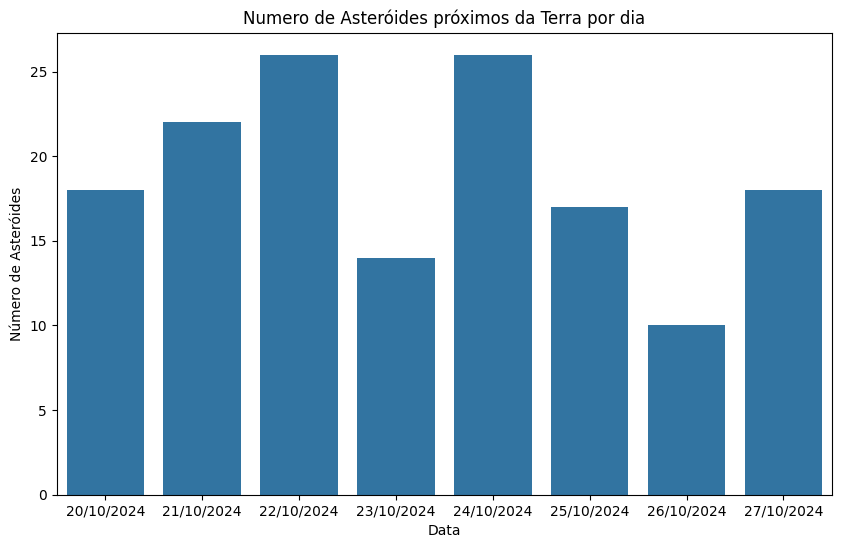

Resposta da IA Generativa:

Os dados fornecidos mostram a variação no número de asteroides próximos da Terra ao longo de uma semana em outubro de 2024. Essa variação pode indicar flutuações normais na atividade de asteroides próximos da Terra, que podem ser influenciadas por diversos fatores astronômicos, como a órbita dos asteroides e a posição da Terra em relação a esses corpos celestes.

Observando os números, percebe-se que não há um padrão consistente; o número de asteroides varia de um máximo de 26 em dois dias distintos (22/10/2024 e 24/10/2024) a um mínimo de 10 no dia 26/10/2024. Essa variação pode sugerir que, em determinados dias, a Terra passa por regiões do espaço onde há mais asteroides ou que esses dias coincidem com condições que tornam a observação mais eficiente, permitindo a detecção de mais asteroides.

Além disso, essa alternância poderia também revelar a sensibilização e o alcance dos instrumentos utilizados para a detecção de asteroides, já que tecnologias difere

In [160]:
asteroids_per_day = df_asteroids['close_approach_date'].value_counts().sort_index()
asteroids_per_day.index = asteroids_per_day.index.strftime('%d/%m/%Y')
plt.figure(figsize=(10,6))
sns.barplot(x=asteroids_per_day.index, y=asteroids_per_day.values)
plt.title('Numero de Asteróides próximos da Terra por dia')
plt.xlabel('Data')
plt.ylabel('Número de Asteróides')
plt.show()

prompt = f"Os dados a seguir mostram o número de asteroides próximos da Terra por dia: {asteroids_per_day.to_dict()}. Comente sobre o que esses dados podem indicar sobre a atividade de asteroides."
response_ai = get_ai_response(prompt)

print('Resposta da IA Generativa:\n')
print(response_ai['choices'][0]['message']['content'])

### Segunda Análise - Proporção de ateroides perigosos/não perigosos á Terra
Importante para ver a proporção de asteroides que trazem algum perigo à Terra, para as entidades possam tomar algum tipo de prevenção contra os perigosos

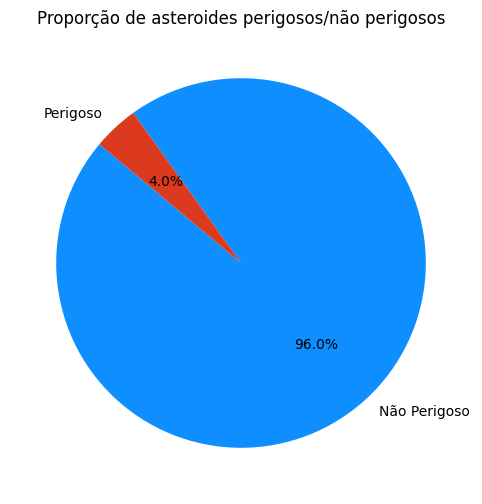

Resposta da IA Generativa:

Os dados fornecidos indicam que há um total de 151 asteroides observados, dos quais 145 são categorizados como "não perigosos" e 6 como "perigosos". Isso sugere que a vasta maioria dos asteroides identificados nesta amostra, cerca de 96%, não representa uma ameaça significativa à Terra. Apenas cerca de 4% dos asteroides são considerados perigosos, o que geralmente implica que eles têm o potencial de se aproximar perigosamente da Terra e são grandes o suficiente para causar danos significativos caso impactem o planeta.

Essa distribuição é consistente com o entendimento atual de que, embora muitos asteroides orbitem dentro do sistema solar, apenas uma pequena fração deles é considerada uma ameaça potencial devido à sua trajetória e tamanho. É importante que as agências espaciais continuem monitorando esses corpos celestes para assegurar-se de que quaisquer riscos potenciais sejam identificados com antecedência, permitindo a implementação de medidas de mitigaç

In [161]:
plt.figure(figsize=(12, 6))
hazardous_count = df_asteroids['is_potentially_hazardous'].value_counts()
plt.pie(hazardous_count, labels=['Não Perigoso', 'Perigoso'], autopct='%1.1f%%', startangle=140, colors=['#0E8EFF', '#DB3A1E'])
plt.title('Proporção de asteroides perigosos/não perigosos')
plt.show()

prompt = f"Os dados a seguir mostram a proporção de asteroides perigosos e não perigosos: {hazardous_count.to_dict()}. Comente sobre."
response_ai = get_ai_response(prompt)

print('Resposta da IA Generativa:\n')
print(response_ai['choices'][0]['message']['content'])

### Terceira Análise - Visualizando correlação entre Menor distância e diâmetro máximo estimado
Importante para visualizar qual é o diâmetro dos asteroides que passam mais perto da Terra
Assim, temos uma noção de quanto estrago o asteroide poderia gerar se chegasse até a Terra
- Nesse caso há um certo padrão nessa distribuição, os asteroides estão mais agrupados no canto inferior esquerdo,  
denotando que os asteroides que chegam mais próximos à Terra geralmente são menores

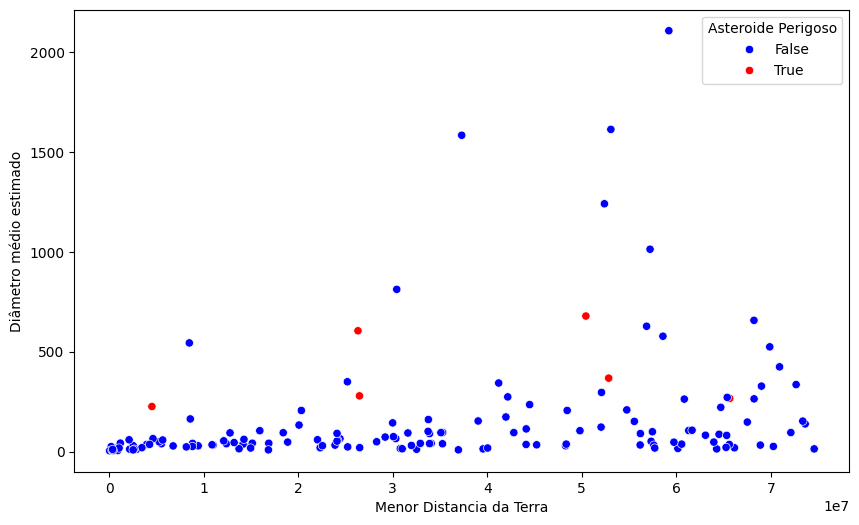

Resposta da IA Generativa:

Esses conjuntos de dados representam duas informações importantes sobre asteroides: o primeiro conjunto é sobre os diâmetros médios estimados dos asteroides, enquanto o segundo conjunto indica a mínima distância estimada de cada asteroide à Terra.

1. **Diâmetros Médios Estimados:**
   - Os valores variam amplamente, de cerca de 4.42 a 2106.41 (provavelmente em metros ou quilômetros, dependendo da unidade usada). Isso reflete a grande diversidade no tamanho dos asteroides.
   - Asteroides menores são mais comuns, mas há também alguns significativamente maiores.

2. **Mínimas Distâncias da Terra:**
   - As distâncias variam de centenas de milhares até dezenas de milhões de unidades, o que pode indicar que algumas destas mínimas distâncias são potencialmente preocupantes do ponto de vista de possíveis impactos.
   - Valores muito baixos, como menos de mil unidades, podem sugerir asteroides que passam muito perto da Terra.

**Interpretações e Considerações:**



In [162]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='miss_distance_km', y='estimated_diameter_mean', hue='is_potentially_hazardous', 
                data=df_asteroids, palette={True: 'red', False: 'blue'})
plt.xlabel('Menor Distancia da Terra')
plt.ylabel('Diâmetro médio estimado')
plt.legend(title='Asteroide Perigoso')
plt.show()

prompt = f"""
O que você pode comentar sobre {df_asteroids['estimated_diameter_mean'].to_dict()} e {df_asteroids['miss_distance_km'].to_dict()} dado que sao valores de diametros medios estimados de um asteroide e a minima distancia de um asteroiude da Terra, respectivamente.
"""

response_ai = get_ai_response(prompt)

print('Resposta da IA Generativa:\n')
print(response_ai['choices'][0]['message']['content'])

### Quarta Análise - Visualizando a distribuição de diametro médio dos asteroides
Importante para observarmos o tamanho dos asteroides que passam perto da Terra, pois assim podemos ter uma noção de estrago que poderiam causar.

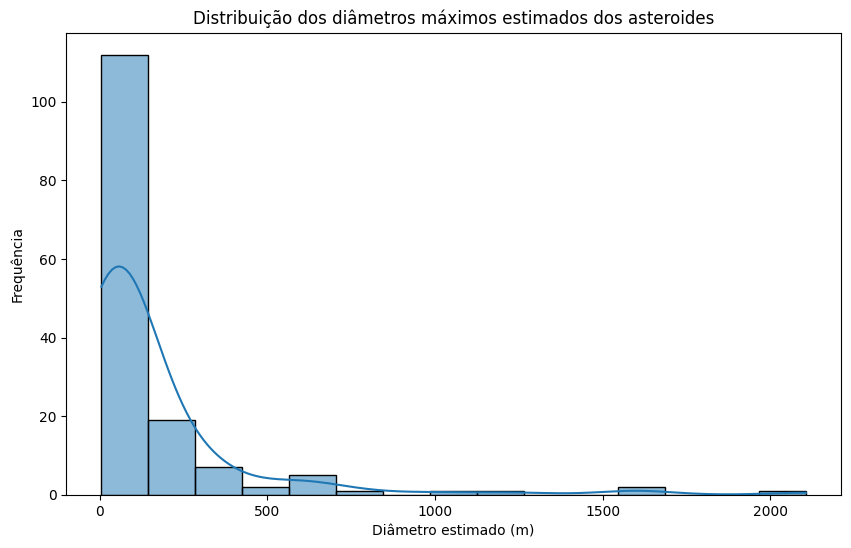

Resposta da IA Generativa:

Para analisar as estimativas dos asteroides apresentadas, primeiro calculamos a média dos valores fornecidos. A média é a soma de todas as estimativas dividida pelo número total de estimativas.

Ao observar os valores dos asteroides, notamos que há muitos valores pequenos (entre 10 e 100) e alguns valores significativamente maiores (acima de 1000), como os asteroides com valores de 2106, 1012, 1612 e 1583. Essas discrepâncias indicam a presença de outliers que podem afetar a média geral.

A distribuição parece não ser uniforme e apresenta uma cauda longa à direita (right-skewed distribution) devido à presença desses valores extremos. Isso sugere uma distribuição assimétrica, onde a maioria das estimativas está concentrada em um intervalo menor, enquanto algumas poucas estimativas são muito grandes.

Essa característica pode implicar que a média será puxada para cima devido aos valores extremos, fornecendo uma visão potencialmente distorcida da "centralidade"

In [163]:
plt.figure(figsize=(10, 6))
sns.histplot(df_asteroids['estimated_diameter_mean'], kde=True, bins=15)
plt.title('Distribuição dos diâmetros máximos estimados dos asteroides')
plt.xlabel('Diâmetro estimado (m)')
plt.ylabel('Frequência')
plt.show()

prompt = f"""
O que você pode comentar sobre a média das etimativas dos asteroides: {df_asteroids['estimated_diameter_mean'].to_dict()}. Comente sobre sua distribuição.
"""

response_ai = get_ai_response(prompt)

print('Resposta da IA Generativa:\n')
print(response_ai['choices'][0]['message']['content'])

### Quinta Análise - Vendo a distribuição das velocidades
Visualizando a distribuição de velocidade dos asteroides

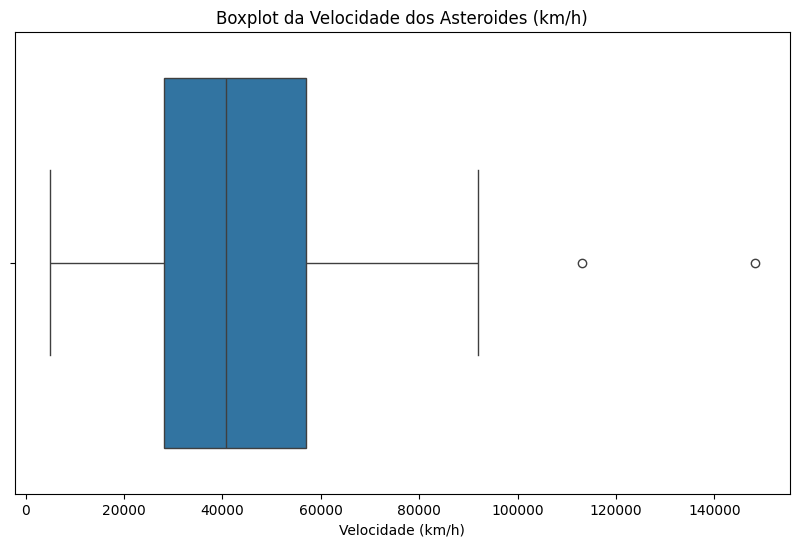

Resposta da IA Generativa:

As velocidades dos asteroides que você forneceu variam significativamente, de cerca de 4.967 km/h até mais de 148.185 km/h. Aqui estão alguns pontos de interesse ao analisar essas velocidades:

1. **Variedade de Velocidades**: A ampla gama de velocidades indica que os asteroides do conjunto de dados possuem características e trajetórias bastante diversas. Isso é comum, pois os asteroides têm órbitas diferentes e podem estar em diferentes partes de suas trajetórias ao redor do sol.

2. **Média e Mediana**: Calcular a média e a mediana dessas velocidades pode dar uma ideia central do comportamento geral dos asteroides no conjunto de dados. Para análise um pouco mais profunda, pode-se também calcular o desvio padrão para ver como as velocidades são distribuídas em torno da média.

3. **Asteroides Extremamente Lentos e Rápidos**: Os asteroides mais lentos (como aquele com velocidade de cerca de 4.967 km/h) podem ser asteroides que estão em órbitas mais distantes

In [164]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='relative_velocity_kmh', data=df_asteroids)
plt.title('Boxplot da Velocidade dos Asteroides (km/h)')
plt.xlabel('Velocidade (km/h)')
plt.show()

prompt = f"""
O que você pode comentar sobre a velocidade dos asteroides: {df_asteroids['relative_velocity_kmh'].to_dict()}.
"""

response_ai = get_ai_response(prompt)

print('Resposta da IA Generativa:\n')
print(response_ai['choices'][0]['message']['content'])

### Tentativa de Predição se o asteroide é perigoso ou não

Criando uma nova função para consumir a api para pegarmos dados do último ano (365 dias), já que o máximo que a api consegue extrair é 7 dias por vez  
e para criarmos modelos melhores precisamos de mais dados

In [174]:
# Configuração de 365 dias e intervalo de 7 dias
total_days = 365
interval_days = 7

# Lista para armazenar todos os dados de asteroides
year_asteroids = []

# Loop para dividir a solicitação em intervalos de 7 dias
for i in range(0, total_days, interval_days):
    end_date = (datetime.now() - timedelta(days=i)).strftime('%Y-%m-%d')
    start_date = (datetime.now() - timedelta(days=i + interval_days - 1)).strftime('%Y-%m-%d')
    
    params = {
        'start_date': start_date,
        'end_date': end_date,
        'api_key': nasa_key
    }
    
    # Fazer a requisição
    response = requests.get(base_url, params=params)
    data = response.json()

    # Processar os dados de cada asteroide, adicionando ao year_asteroids
    for date in data['near_earth_objects']:
        for asteroid in data['near_earth_objects'][date]:
            year_asteroids.append({
                'name': asteroid['name'],
                'close_approach_date': asteroid['close_approach_data'][0]['close_approach_date'],
                'miss_distance_km': float(asteroid['close_approach_data'][0]['miss_distance']['kilometers']),
                'relative_velocity_kmh': float(asteroid['close_approach_data'][0]['relative_velocity']['kilometers_per_hour']),
                'is_potentially_hazardous': asteroid['is_potentially_hazardous_asteroid'],
                'absolute_magnitude_h': asteroid['absolute_magnitude_h'],
                'estimated_diameter_min': asteroid['estimated_diameter']['meters']['estimated_diameter_min'],
                'estimated_diameter_max': asteroid['estimated_diameter']['meters']['estimated_diameter_max']
            })

# Convertendo para DataFrame
df_year_asteroids = pd.DataFrame(year_asteroids)

In [175]:
df_year_asteroids['estimated_diameter_mean'] = (df_year_asteroids['estimated_diameter_max'] + df_year_asteroids['estimated_diameter_min']) / 2

Definição da função para retornar as métricas

In [176]:
def scores(y_true, y_pred, features, sampling, model, sampling_method):

    if sampling_method == 'undersampling':
        sampling_method = f'US - {sampling}'  # Descreve a taxa de balanceamento
    elif sampling_method == 'oversampling':
        sampling_method = f'ADASYN - {sampling}'  # Método de amostragem ADASYN
    else:
        sampling_method = 'class_weight'
        
    return {
        "Features": features,
        "Algoritmo": str(model),
        "Acurácia": round(accuracy_score(y_true, y_pred),3),
        "Precisão": round(precision_score(y_true, y_pred, zero_division=0), 3),
        "Recall": round(recall_score(y_true, y_pred, zero_division=0), 3),
        "F1-Score": round(f1_score(y_true, y_pred),3),
        "AUC-ROC": round(roc_auc_score(y_true, y_pred),3),
        "Método": str(sampling_method)
    }

Variáveis para inputar nos modelos

In [177]:
sampling = [0.5, 0.6, 0.7]
sampling_method = ['undersampling', 'oversampling', 'class_weight']
model = [DT(random_state=0), RF(random_state=0), LR(random_state=0, max_iter=200), XGB(random_state=0)]

features = ['feat1', ['relative_velocity_kmh', 'estimated_diameter_min', 'estimated_diameter_max', 'estimated_diameter_mean', 'miss_distance_km', 'absolute_magnitude_h']]

products = []
for method in sampling_method:
    for samp in (sampling if method != 'class_weight' else [1]):
            for mod in model:
                    products.append({
                        'sampling_method': method,
                        'sampling': samp,
                        'model': mod,
                        'feature': features
                    })

Todas as combinações de variáveis

In [178]:
pd.DataFrame(products)

,sampling_method,sampling,model,feature
0,undersampling,0.5,DecisionTreeClassifier(random_state=0),"[feat1, [relative_velocity_kmh, estimated_diam..."
1,undersampling,0.5,RandomForestClassifier(random_state=0),"[feat1, [relative_velocity_kmh, estimated_diam..."
2,undersampling,0.5,"LogisticRegression(max_iter=200, random_state=0)","[feat1, [relative_velocity_kmh, estimated_diam..."
3,undersampling,0.5,"XGBClassifier(base_score=None, booster=None, c...","[feat1, [relative_velocity_kmh, estimated_diam..."
4,undersampling,0.6,DecisionTreeClassifier(random_state=0),"[feat1, [relative_velocity_kmh, estimated_diam..."
5,undersampling,0.6,RandomForestClassifier(random_state=0),"[feat1, [relative_velocity_kmh, estimated_diam..."
6,undersampling,0.6,"LogisticRegression(max_iter=200, random_state=0)","[feat1, [relative_velocity_kmh, estimated_diam..."
7,undersampling,0.6,"XGBClassifier(base_score=None, booster=None, c...","[feat1, [relative_velocity_kmh, estimated_diam..."
8,undersampling,0.7,DecisionTreeClassifier(random_state=0),"[feat1, [relative_velocity_kmh, estimated_diam..."
9,undersampling,0.7,RandomForestClassifier(random_state=0),"[feat1, [relative_velocity_kmh, estimated_diam..."


Função principal para a criação dos modelos preditivos e testes   
Função baseada no RMMS[Giusti et al. 2022] (REGRESSIVE MULTI-DIMENSIONAL MODEL SELECTION)

In [179]:
def classification_predictions(df, features, model, sampling=None, sampling_method=None, return_model=False):

    X = df[features[1]]
    y = df['is_potentially_hazardous']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    if sampling_method == "undersampling":
        y_train = pd.concat([y_train[y_train==1], y_train[y_train==0].sample(int((len(y_train[y_train == 1]) * sampling)/(1 - sampling)), random_state=0)])
        X_train = X_train.loc[y_train.index]
    elif sampling_method == "oversampling":
        ada = ADASYN(sampling_strategy=sampling, random_state=0)
        X_train, y_train = ada.fit_resample(X_train, y_train)
    elif sampling_method == "class_weight":
        model.set_params(class_weight='balanced')

    # Treinamento do modelo
    model.fit(X_train, y_train)

    # Predições após o treinamento
    y_pred = model.predict(X_test)

    if return_model:
        return model, y_pred, X_test, y_test, df
    else:
        # Métricas avaliativas comparando o conjunto de teste e o conjunto previsto
        result = scores(y_test, y_pred, features[0], sampling, model, sampling_method=sampling_method)   
        return result

Chamada da função principal e armazenamento dos resultados

In [180]:
results = []
for product in products:
                results.append(classification_predictions(
                    df_year_asteroids, 
                    features=product['feature'], 
                    model=product['model'], 
                    sampling=product['sampling'], 
                    sampling_method=product['sampling_method'], 
                ))

Observando os resultados e ordenando pelo F1-Score

In [181]:
df_results = pd.DataFrame(results)
df_results.sort_values('F1-Score', ascending=False).reset_index(drop=True)

,Features,Algoritmo,Acurácia,Precisão,Recall,F1-Score,AUC-ROC,Método
0,feat1,DecisionTreeClassifier(random_state=0),0.908,0.373,0.652,0.474,0.789,ADASYN - 0.6
1,feat1,"XGBClassifier(base_score=None, booster=None, c...",0.908,0.371,0.641,0.470,0.784,ADASYN - 0.7
2,feat1,RandomForestClassifier(random_state=0),0.905,0.363,0.663,0.469,0.792,ADASYN - 0.7
3,feat1,DecisionTreeClassifier(class_weight='balanced'...,0.934,0.482,0.446,0.463,0.707,class_weight
4,feat1,RandomForestClassifier(random_state=0),0.910,0.371,0.609,0.461,0.769,ADASYN - 0.5
5,feat1,RandomForestClassifier(random_state=0),0.903,0.355,0.641,0.457,0.781,ADASYN - 0.6
6,feat1,"XGBClassifier(base_score=None, booster=None, c...",0.906,0.359,0.609,0.452,0.768,ADASYN - 0.5
7,feat1,RandomForestClassifier(random_state=0),0.870,0.305,0.815,0.444,0.845,US - 0.7
8,feat1,RandomForestClassifier(random_state=0),0.854,0.289,0.891,0.436,0.871,US - 0.6
9,feat1,DecisionTreeClassifier(random_state=0),0.905,0.349,0.576,0.434,0.752,ADASYN - 0.7
